# Deep Q-Network (DQN) for the Navigation Task
---
In this notebook, I implemented a DQN for the 1st project "Navigation in Banana Land". The implementation is based on my solution to the coding exercise and adopted from the open AI environment to the UnityAgents environment. I implemented two basic algorithms, the "classic" Deep Q-Learning algorithm with soft target updates and a Dueling DQN Network.


### 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

!pip -q install ./python

#!python -m pip install pyvirtualdisplay
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

#is_ipython = 'inline' in plt.get_backend() #plt.get_backend() gibt einen String zurück, "inline" in String liefert 'True' wenn "inline" in diesem String ist
#if is_ipython:
#    from IPython import display

#plt.ion() #turn the interactive mode on

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
from unityagents import UnityEnvironment
from dqn_agent import Agent

env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size=state_size, action_size=action_size, seed=0)



INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
print(env.brain_names)
brain = env.brains[brain_name]

['BananaBrain']


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)


Number of agents: 1
Number of actions: 4
States look like: [ 0.          1.          0.          0.          0.16895212  0.          1.
  0.          0.          0.20073597  1.          0.          0.          0.
  0.12865657  0.          1.          0.          0.          0.14938059
  1.          0.          0.          0.          0.58185619  0.          1.
  0.          0.          0.16089135  0.          1.          0.          0.
  0.31775284  0.          0.        ]
States have length: 37


In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: 1.10
Episode 200	Average Score: 4.88
Episode 300	Average Score: 7.73
Episode 400	Average Score: 9.76
Episode 500	Average Score: 12.44
Episode 541	Average Score: 13.00
Environment solved in 441 episodes!	Average Score: 13.00


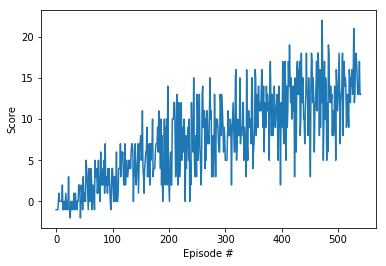

In [6]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0: #solved if +13 over 100 consecutive episodes
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Agent runs greedy policy

In this cell, the trained agent runs the trained greedy policy a few episodes in the environment

In [7]:
# load the weights from file
# original: agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth', map_location=lambda storage, loc: storage))

#torch.load('my_file.pt', map_location=lambda storage, loc: storage) #forces all tensors to be on CPU

for i in range(3):

    env_info = env.reset(train_mode=False)[brain_name] 
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
            
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    
    print("Score this time: {}".format(score))
            
env.close()

Score this time: 10.0
Score this time: 11.0
Score this time: 19.0
